In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_function=nn.Tanh()):
        super(Net, self).__init__()

        self.layer_names = []
        prev_size = input_size

        # Add hidden layers
        for idx, size in enumerate(hidden_layer_sizes):
            linear_name = f"fc{idx + 1}"
            activation_name = f"activation{idx + 1}"
            
            setattr(self, linear_name, nn.Linear(prev_size, size))
            setattr(self, activation_name, type(activation_function)())

            self.layer_names.extend([linear_name, activation_name])
            
            prev_size = size
        
        # Add output layer
        linear_name = f"fc{len(hidden_layer_sizes) + 1}"
        setattr(self, linear_name, nn.Linear(prev_size, output_size))
        self.layer_names.append(linear_name)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        for layer_name in self.layer_names:
            layer = getattr(self, layer_name)
            x = layer(x)

        return x


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

import matplotlib.pyplot as plt

def build_and_train_model(train_loader, val_loader, test_loader,
                          input_size=784, hidden_layer_sizes=[512, 512],
                          activation_function=nn.ReLU(), output_size=10, 
                          optimizer_cls=optim.Adam, loss_function=nn.CrossEntropyLoss(),
                          lr=0.001, epochs=10):
    
    device = 'mps'
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Net(input_size, hidden_layer_sizes, output_size, activation_function).to(device)
    optimizer = optimizer_cls(model.parameters(), lr=lr)

    # Lists to store values for each epoch
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        val_accuracy = evaluate(model, val_loader, device)

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    test_accuracy = evaluate(model, test_loader, device)
    print(f'\nTest Accuracy: {test_accuracy:.2f}%')
    
    return model, train_losses, val_accuracies

def plot_training(train_losses, val_accuracies):
    epochs = len(train_losses)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()



In [27]:
# Load MNIST Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform)

# Splitting the training dataset into training and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Epoch [1/10] - Training Loss: 1.2085, Validation Accuracy: 81.38%
Epoch [2/10] - Training Loss: 0.5371, Validation Accuracy: 88.38%
Epoch [3/10] - Training Loss: 0.3837, Validation Accuracy: 88.35%
Epoch [4/10] - Training Loss: 0.2984, Validation Accuracy: 92.58%
Epoch [5/10] - Training Loss: 0.2504, Validation Accuracy: 93.83%
Epoch [6/10] - Training Loss: 0.2208, Validation Accuracy: 94.34%
Epoch [7/10] - Training Loss: 0.1916, Validation Accuracy: 94.53%
Epoch [8/10] - Training Loss: 0.1734, Validation Accuracy: 95.26%
Epoch [9/10] - Training Loss: 0.1600, Validation Accuracy: 95.11%
Epoch [10/10] - Training Loss: 0.1411, Validation Accuracy: 95.44%

Test Accuracy: 95.44%


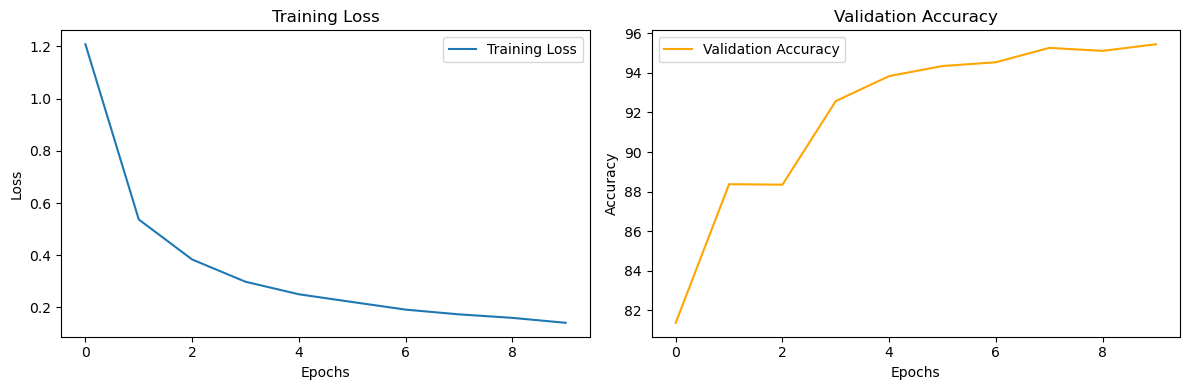

In [28]:
# NOTE: getting it to work with tanh required a much smaller learning rate
model, train_losses, val_accuracies = build_and_train_model(train_loader, val_loader, test_loader, epochs= 10, 
                                                            #hidden_layer_sizes = [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512],
                                                            hidden_layer_sizes = [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512],
                                                            activation_function=nn.Tanh(), lr=0.0001)
                                                            
plot_training(train_losses, val_accuracies)


In [36]:
# Save model's state_dict
path = "./mnist_model_tanh.pth"
torch.save(model.state_dict(), path)

print(f"Model saved at {path}")


Model saved at ./mnist_model_tanh.pth


code to load the model  

#Initialize a model
loaded_model = Net(input_size=784, hidden_layer_sizes=[512, 512], output_size=10)
loaded_model.load_state_dict(torch.load(path))
loaded_model.eval()  # Set to evaluation mode

#if you're using a GPU:
#loaded_model = loaded_model.to('cuda')


# Integration of statistical physics variance

# traditional variance

In [86]:
# model = Net(input_size=784, hidden_layer_sizes=[512, 512, 512, 512, 512, 512,512, 512, 512 ], output_size=10, activation_function=nn.Tanh())

In [29]:
from torchsummary import summary

device = 'cpu'
# Assuming your model and a device (cuda or cpu) are already defined
model = model.to(device)

# The summary function requires the size of the input.
# For MNIST, the input size is (1, 28, 28).
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              Tanh-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              Tanh-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              Tanh-6                  [-1, 512]               0
            Linear-7                  [-1, 512]         262,656
              Tanh-8                  [-1, 512]               0
            Linear-9                  [-1, 512]         262,656
             Tanh-10                  [-1, 512]               0
           Linear-11                  [-1, 512]         262,656
             Tanh-12                  [-1, 512]               0
           Linear-13                  [-1, 512]         262,656
             Tanh-14                  [

In [30]:
device = 'cpu'

# Define a hook to collect activations
activations = {}

def create_hook(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

for name, layer in model.named_modules():
    if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
        layer.register_forward_hook(create_hook(name))

# Run inference on the test set
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)

# Calculate and print variance for each layer's activations
variances = {key: torch.var(act, dim=0) for key, act in activations.items()}

for layer_name, variance in variances.items():
    print(f"Layer {layer_name} - Variance: {variance.mean().item()}")


Layer fc1 - Variance: 1.165509581565857
Layer activation1 - Variance: 0.33394721150398254
Layer fc2 - Variance: 1.0050572156906128
Layer activation2 - Variance: 0.30533674359321594
Layer fc3 - Variance: 0.6959232091903687
Layer activation3 - Variance: 0.24294930696487427
Layer fc4 - Variance: 0.44266435503959656
Layer activation4 - Variance: 0.16992172598838806
Layer fc5 - Variance: 0.17713414132595062
Layer activation5 - Variance: 0.08479315787553787
Layer fc6 - Variance: 0.060424938797950745
Layer activation6 - Variance: 0.04772194102406502
Layer fc7 - Variance: 0.03610633686184883
Layer activation7 - Variance: 0.031677450984716415
Layer fc8 - Variance: 0.025323422625660896
Layer activation8 - Variance: 0.022911833599209785
Layer fc9 - Variance: 0.01922006718814373
Layer activation9 - Variance: 0.017847897484898567
Layer fc10 - Variance: 0.015630554407835007
Layer activation10 - Variance: 0.014651605859398842
Layer fc11 - Variance: 0.014022715389728546
Layer activation11 - Variance: 

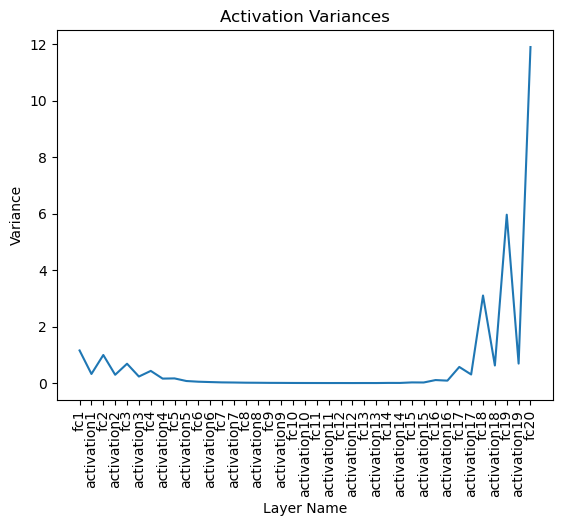

In [31]:
import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names, variance_values)
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_6265/4218322238.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(fc_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_6265/4218322238.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


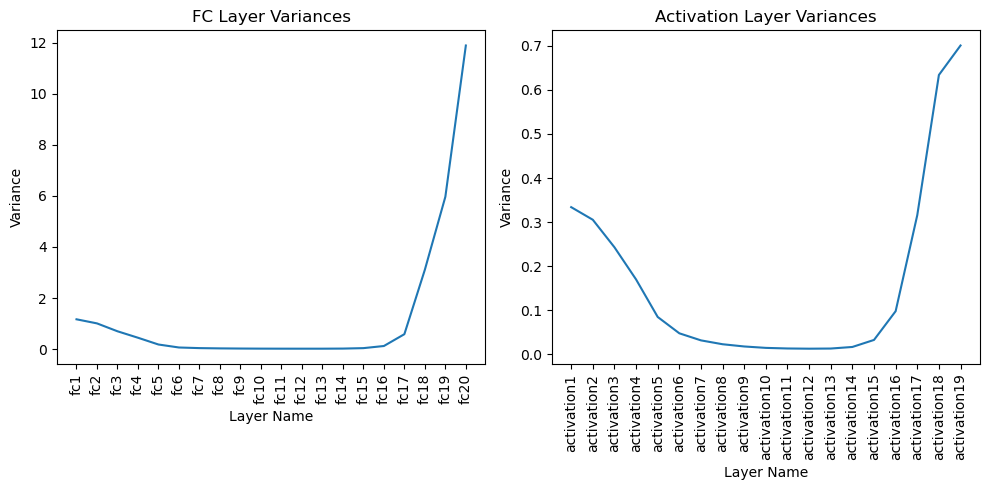

In [32]:
import matplotlib.pyplot as plt

# Create a list of layer names and variances for fc layers
fc_layer_names = [name for name in variances.keys() if 'fc' in name]
fc_variance_values = [variance.mean().item() for name, variance in variances.items() if 'fc' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'fc' not in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'fc' not in name]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the variances for fc layers
axs[0].plot(fc_layer_names, fc_variance_values)
axs[0].set_xticklabels(fc_layer_names, rotation=90)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Variance')
axs[0].set_title('FC Layer Variances')

# Plot the variances for activation layers
axs[1].plot(activation_layer_names, activation_variance_values)
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Variance')
axs[1].set_title('Activation Layer Variances')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

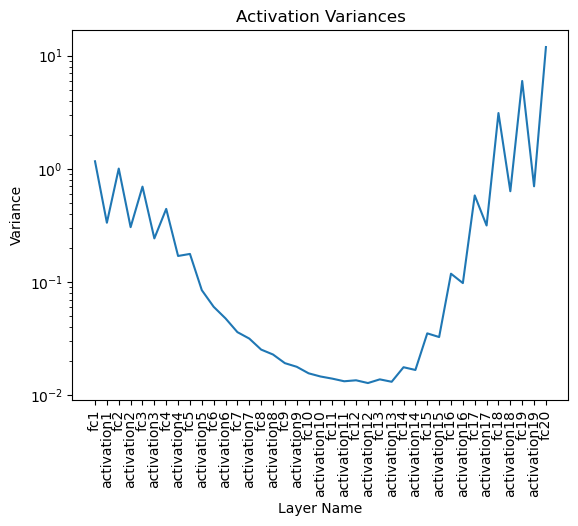

In [33]:
import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names, variance_values)
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.yscale('log')
plt.title('Activation Variances')
plt.show()

## fashion mnist 

In [34]:
import torch
from torchvision import datasets, transforms

# Define the device
device = 'cpu'

# Define the transformation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the test set
test_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

# Define a hook to collect activations
activations = {}

def create_hook(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

for name, layer in model.named_modules():
    if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
        layer.register_forward_hook(create_hook(name))

# Run inference on the test set
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)

# Calculate and print variance for each layer's activations
variances = {key: torch.var(act, dim=0) for key, act in activations.items()}

for layer_name, variance in variances.items():
    print(f"Layer {layer_name} - Variance: {variance.mean().item()}")

Layer fc1 - Variance: 0.6884750127792358
Layer activation1 - Variance: 0.22987845540046692
Layer fc2 - Variance: 0.5331777930259705
Layer activation2 - Variance: 0.18488755822181702
Layer fc3 - Variance: 0.3749525547027588
Layer activation3 - Variance: 0.13938672840595245
Layer fc4 - Variance: 0.2302747368812561
Layer activation4 - Variance: 0.09115758538246155
Layer fc5 - Variance: 0.09622125327587128
Layer activation5 - Variance: 0.04882533848285675
Layer fc6 - Variance: 0.0313035249710083
Layer activation6 - Variance: 0.02643767185509205
Layer fc7 - Variance: 0.017768872901797295
Layer activation7 - Variance: 0.01615440472960472
Layer fc8 - Variance: 0.01232212781906128
Layer activation8 - Variance: 0.011523141525685787
Layer fc9 - Variance: 0.009534552693367004
Layer activation9 - Variance: 0.009048224426805973
Layer fc10 - Variance: 0.007734945043921471
Layer activation10 - Variance: 0.007391051389276981
Layer fc11 - Variance: 0.006928851827979088
Layer activation11 - Variance: 0.

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_6265/4218322238.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(fc_layer_names, rotation=90)
/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_6265/4218322238.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


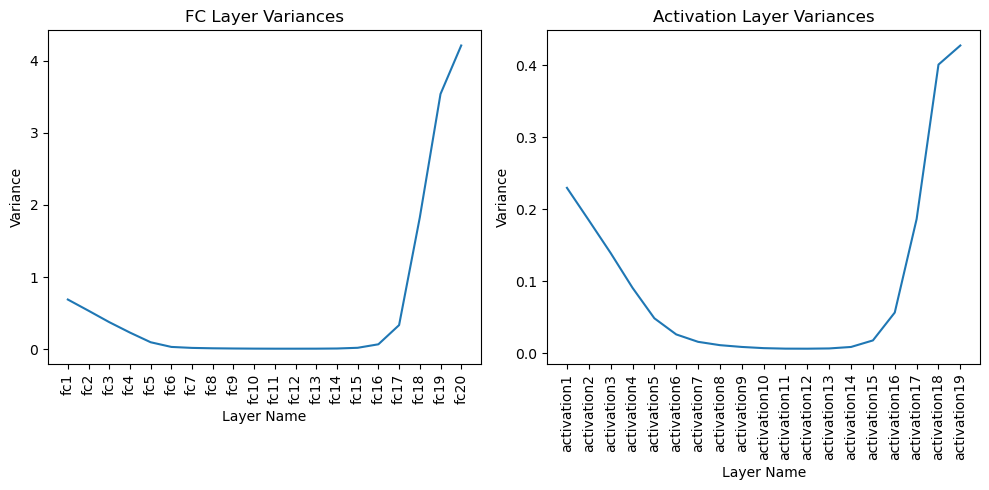

In [35]:
import matplotlib.pyplot as plt

# Create a list of layer names and variances for fc layers
fc_layer_names = [name for name in variances.keys() if 'fc' in name]
fc_variance_values = [variance.mean().item() for name, variance in variances.items() if 'fc' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'fc' not in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'fc' not in name]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the variances for fc layers
axs[0].plot(fc_layer_names, fc_variance_values)
axs[0].set_xticklabels(fc_layer_names, rotation=90)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Variance')
axs[0].set_title('FC Layer Variances')

# Plot the variances for activation layers
axs[1].plot(activation_layer_names, activation_variance_values)
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Variance')
axs[1].set_title('Activation Layer Variances')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'conv' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'conv' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'tanh' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'tanh' in name]

# Create a list of layer names and variances for pool layers
pool_layer_names = [name for name in variances.keys() if 'pool' in name]
pool_variance_values = [variance.mean().item() for name, variance in variances.items() if 'pool' in name]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the variances for fc layers
axs[0].plot(conv_layer_names, conv_variance_values)
axs[0].set_xticklabels(conv_layer_names, rotation=90)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Variance')
axs[0].set_title('FC Layer Variances')

# Plot the variances for activation layers
axs[1].plot(activation_layer_names, activation_variance_values)
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Variance')
axs[1].set_title('Activation Layer Variances')

# Plot the variances for pool layers
axs[2].plot(pool_layer_names, pool_variance_values)
axs[2].set_xticklabels(pool_layer_names, rotation=90)
axs[2].set_xlabel('Layer Name')
axs[2].set_ylabel('Variance')
axs[2].set_title('Pool Layer Variances')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()